In [ ]:
!mamba create -n py37 -y
!source /opt/conda/bin/activate py37 && mamba install python=3.7 jupyter mamba -y

!sudo rm /opt/conda/bin/python3
!sudo ln -sf /opt/conda/envs/py37/bin/python3 /opt/conda/bin/python3
!sudo rm /opt/conda/bin/python3.10
!sudo ln -sf /opt/conda/envs/py37/bin/python3 /opt/conda/bin/python3.10
!sudo rm /opt/conda/bin/python
!sudo ln -sf /opt/conda/envs/py37/bin/python3 /opt/conda/bin/python

In [1]:
!python --version

Python 3.7.12


In [ ]:
!pip install chardet openpyxl graphlearning stellargraph[demos]==1.2.1

In [2]:
import stellargraph as sg
import pandas as pd
import numpy as np

from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

In [10]:
import stellargraph as sg
from stellargraph.mapper import CorruptedGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, DeepGraphInfomax

import pandas as pd
from sklearn import model_selection, preprocessing
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers, callbacks

In [3]:
W = pd.read_csv("/kaggle/input/da324dataminingproject2/adjacency.csv")
W.head()

,0,1,2,3,4,5,6,7,8,9,...,11942,11943,11944,11945,11946,11947,11948,11949,11950,11951
0,0,1,0,0,1,1,0,0,0,0,...,1,1,1,1,1,1,0,0,1,1
1,1,0,0,0,1,0,1,1,0,1,...,1,1,1,1,1,1,1,0,1,1
2,0,0,0,0,0,1,0,0,0,1,...,0,0,1,1,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,1,1,...,1,0,0,0,0,1,0,1,1,1
4,1,1,0,1,0,0,0,0,1,1,...,1,1,1,0,1,1,0,1,1,1


In [4]:
X = pd.read_excel("/kaggle/input/da324dataminingproject2/attributes.xlsx")
X.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,-6.3128,-5.58510,-3.0679,12.9880,9.00260,-5.5361,-1.0356,10.1650,-8.6108,4.3228,...,-2.8601,-24.768,18.2130,7.3551,44.382,18.659,-6.0441,2.9410,29.0100,-32.906
1,1.3902,-0.44661,-3.7137,-12.8420,4.47870,4.8796,3.0049,-5.9097,-7.3532,13.8250,...,-29.5170,-35.920,7.0253,-12.0390,43.115,-71.516,-25.2070,-6.4823,96.8440,-67.232
2,-8.3044,-3.45690,6.5153,-12.0090,-6.76200,-1.2466,-5.9627,9.9527,-6.2527,12.3210,...,13.8550,17.979,-25.7940,16.4910,13.304,-25.527,-52.4930,79.9770,8.9831,30.085
3,-6.3335,-5.83730,-1.5020,-5.0176,6.49150,-25.8940,11.6040,5.1414,-2.5690,6.2234,...,35.8110,18.597,-27.5800,12.5700,10.744,-38.588,10.7530,2.9410,29.0100,-32.906
4,5.6422,-2.65020,4.1389,-5.6228,0.74712,2.7475,-6.3798,9.0944,-13.5540,10.9460,...,7.1254,-38.921,-67.4780,29.1870,27.917,13.592,19.5940,31.2670,7.3044,-84.121


In [36]:
seed = pd.read_excel("/kaggle/input/da324dataminingproject2/seed.xlsx")
seed.head()

,5793,10805,2258
0,8938,7423,1853
1,4566,902,5633
2,1529,9833,7709
3,1942,935,4907
4,6345,10950,2174


In [5]:
def get_edges_from_adjacency_matrix(adj_matrix):
    rows, cols = np.where(adj_matrix != 0)
    edges = list(zip(rows, cols))
    return edges

edges = get_edges_from_adjacency_matrix(W)

In [6]:
square_edges = pd.DataFrame(edges, columns = ['source', 'target'])
square_node_data = X

In [7]:
G = StellarGraph(square_node_data, square_edges)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 11952, Edges: 76640260

 Node types:
  default: [11952]
    Features: float32 vector, length 103
    Edge types: default-default->default

 Edge types:
    default-default->default: [76640260]
        Weights: all 1 (default)
        Features: none


In [8]:
fullbatch_generator = FullBatchNodeGenerator(G)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


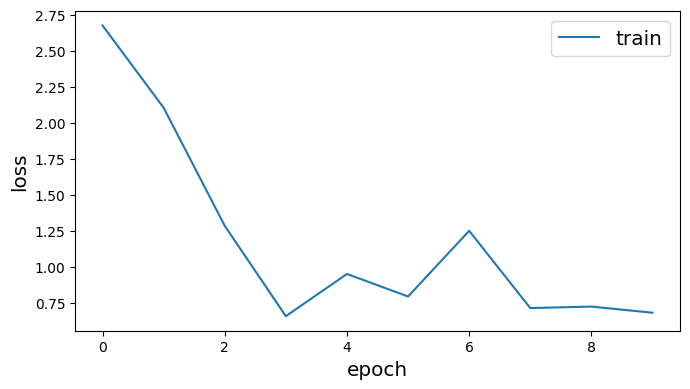

In [37]:
def make_gcn_model():
    # function because we want to create a second one with the same parameters later
    return GCN(
        layer_sizes=[16, 16],
        activations=["relu", "relu"],
        generator=fullbatch_generator,
        dropout=0.4,
    )


pretrained_gcn_model = make_gcn_model()
infomax = DeepGraphInfomax(pretrained_gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

dgi_model = Model(inputs=x_in, outputs=x_out)
dgi_model.compile(
    loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=optimizers.Adam(lr=1e-3)
)
epochs = 10
dgi_es = callbacks.EarlyStopping(monitor="loss", patience=50, restore_best_weights=True)
dgi_history = dgi_model.fit(gen, epochs=epochs, verbose=0, callbacks=[dgi_es])
sg.utils.plot_history(dgi_history)

In [38]:
seed = seed.transpose().reset_index().transpose().reset_index(drop = True)
train = seed.stack().reset_index().drop(columns = ['level_1']).set_index(0).rename(columns = {'level_0':'cluster'})

In [39]:
train_classes = train['cluster'].values

In [40]:
np.array(train.index)

array([ 5793, 10805,  2258,  8938,  7423,  1853,  4566,   902,  5633,
        1529,  9833,  7709,  1942,   935,  4907,  6345, 10950,  2174,
        9219,  5958,  9646,  2193,  5757,  6346,  5863,  5838,  9831,
        9897,  6314,  2080])

In [41]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train['cluster'].values)
# test_targets = target_encoding.transform(test_classes)

In [42]:
train_gen = fullbatch_generator.flow(np.array(train.index), train_targets)
# test_gen = fullbatch_generator.flow(test_classes.index, test_targets)

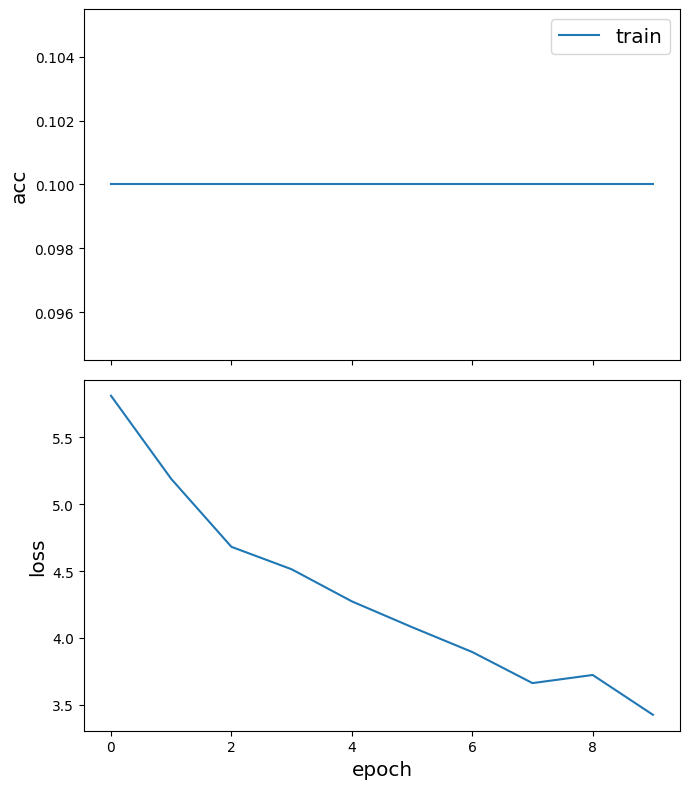

In [43]:
pretrained_x_in, pretrained_x_out = pretrained_gcn_model.in_out_tensors()

pretrained_predictions = tf.keras.layers.Dense(
    units=train_targets.shape[1], activation="softmax"
)(pretrained_x_out)

pretrained_model = Model(inputs=pretrained_x_in, outputs=pretrained_predictions)
pretrained_model.compile(
    optimizer=optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=["acc"],
)

pretrained_history = pretrained_model.fit(
    train_gen,
    epochs=epochs,
    verbose=0,
)
sg.utils.plot_history(pretrained_history)